In [18]:
# Don't use this or you can't visualise the data for some reason
#import findspark
#import streamlit
#findspark.init()

In [19]:
#Imports
import pyspark
from pyspark import SparkContext, SparkConf
from collections import Counter
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split, col

from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master('local[10]').config('spark.driver.memory','10g').getOrCreate()

conf = SparkConf().setAppName('Project').setMaster('local')
sparkContext = SparkContext.getOrCreate(conf=conf) #SparkContext(conf = conf)

In [20]:
# Read in and assign column names
# Income data
Income = spark.read.csv('income_csv_cleaned_no_commas.csv',header=False)
Income = Income.toDF('Area_code','Area','Self_num_ind','Self_mean','Self_median','Num_ind','Mean','Median','Pens_num_ind','Pens_mean',
                     'Pens_median','Other_num_ind','Other_mean','Other_median','Tot_num_ind','Tot_mean','Tot_median','Tax_num_ind','Tax_mean','Tax_median','Tot_tax')

# Drop not applicable
Income = Income.na.drop()
Income = Income.filter(Income.Area_code!='Not applicable')

# Remove original formatting
Income = Income.filter(Income.Area!='Region/County')

# Population data
Population = spark.read.csv('population_data.csv',header=False)
Population = Population.toDF('Code','Name','Geography','All_ages','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15',
                     '16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37',
                     '38','39','40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59',
                     '60','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90+')

# Drop not applicable
Population = Population.na.drop()

# Remove original formatting
Population = Population.filter(Population.Code!='Code')

# Income data
Statements = spark.read.csv('Transposed_Consolidated_Income_Statements.csv',header=False)
Statements = Statements.toDF('Company','Fina_period','State','Revenue','Cost','Gross','Other','Disp_close','Admin','Operating','Fin_out','Fin_in','Share_loss','Before_tax','Tax','Profit')

# Remove original formatting
Statements = Statements.drop(col('Company'))
Statements = Statements.drop(col('Fina_period'))
Statements = Statements.drop(col('State'))

# Remove original formatting
Statements = Statements.filter(Statements.Cost!='Cost of sales')

# Stores data
Stores = spark.read.csv('Stores1.csv',header=False)
Stores = Stores.toDF('Codes','Name','Morrisons','Tesco','Sainsbury')

#Stores.show()

In [21]:
#Population.show()

In [22]:
#Statements.show()

In [23]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id

# Condensing the data to only what is relevant
# Dropping self employement data

# Income condensed
Cond_Inc = Income

Cond_Inc = Cond_Inc.drop(col('Self_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Self_mean'))
Cond_Inc = Cond_Inc.drop(col('Self_median'))

# Dropping pension data
Cond_Inc = Cond_Inc.drop(col('Pens_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Pens_mean'))
Cond_Inc = Cond_Inc.drop(col('Pens_median'))

# Remove the non-applicable areas
Cond_Inc = Cond_Inc.filter(Cond_Inc.Area_code != 'Not applicable')

# Population condensed
Cond_Pop = Population

# Dropping columns for individual ages
for colu in range(0,90):
    Cond_Pop = Cond_Pop.drop('',col(str(colu)))

Cond_Pop = Cond_Pop.drop(col('90+'))

# Dropping repeated data in both population and income
Cond_Pop = Cond_Pop.drop(col('Name'))

# Join two dataframes
Data = Cond_Pop.join(Cond_Inc,Cond_Inc.Area_code == Cond_Pop.Code,'inner')
Data = Data.drop(col('Area_code'))

# Add new primary key
Data = Data.withColumn("id", monotonically_increasing_id())

# Get all codes in the new dataframe
codes = [row.Code for row in Data.select('Code').collect()]

# Temporary store for string data types with primary key
Temp_Store = Data.select('id','Code','Area','Geography')
Temp_Store = Temp_Store.withColumnRenamed('id', 'id1')

# Drop string data type columns
Data = Data.drop(col('Code'))
Data = Data.drop(col('Area'))
Data = Data.drop(col('Geography'))

# Changes data type
for c in Data.columns:
    Data = Data.withColumn(c, F.col(c).cast(IntegerType()))

# Creates a single database
Cast_Data = Data.join(Temp_Store,Data.id == Temp_Store.id1,'full_outer')
Cast_Data = Cast_Data.drop(col('id1'))

Cast_Data = Cast_Data.filter(Cast_Data.id!=0)

Cast_Data.show()

+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+-------------------+
|All_ages|Num_ind| Mean|Median|Other_num_ind|Other_mean|Other_median|Tot_num_ind|Tot_mean|Tot_median|Tax_num_ind|Tax_mean|Tax_median|Tot_tax| id|     Code|                Area|          Geography|
+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+-------------------+
| 2711380|    929|30200| 24700|          508|      3840|          31|       1230|   31500|     24900|       1230|    4110|      2230|   5060|  1|E12000001|          North East|             Region|
| 1153212|    396|30500| 25000|          197|      3800|          29|        508|   31700|     25200|        508|    4120|      2290|   2090|  2|E11000007|         Tyne & Wear|Metropolitan County|
| 7600126|   26

In [ ]:
# Regions based data
# Create region table
Region = Cond_Pop.join(Stores,Stores.Codes == Cond_Pop.Code,'inner')
Region = Region.drop(col('Codes'))

Region = Region.filter(Region.Geography!='Country')


+---------+---------+--------+--------------------+---------+-----+---------+
|     Code|Geography|All_ages|                Name|Morrisons|Tesco|Sainsbury|
+---------+---------+--------+--------------------+---------+-----+---------+
|E12000001|   Region| 2711380|          NORTH EAST|       31| #N/A|     #N/A|
|E12000002|   Region| 7600126|          NORTH WEST|       67| #N/A|     #N/A|
|E12000003|   Region| 5594125|YORKSHIRE AND THE...|       55| #N/A|     #N/A|
|E12000004|   Region| 4991265|       EAST MIDLANDS|       39| #N/A|     #N/A|
|E12000005|   Region| 6085687|       WEST MIDLANDS|       48| #N/A|     #N/A|
|E12000006|   Region| 6468665|                EAST|       47| #N/A|     #N/A|
|E12000007|   Region| 8945309|              LONDON|       32| #N/A|     #N/A|
|E12000008|   Region| 9482507|          SOUTH EAST|       45| #N/A|     #N/A|
|E12000009|   Region| 5811259|          SOUTH WEST|       48| #N/A|     #N/A|
+---------+---------+--------+--------------------+---------+---

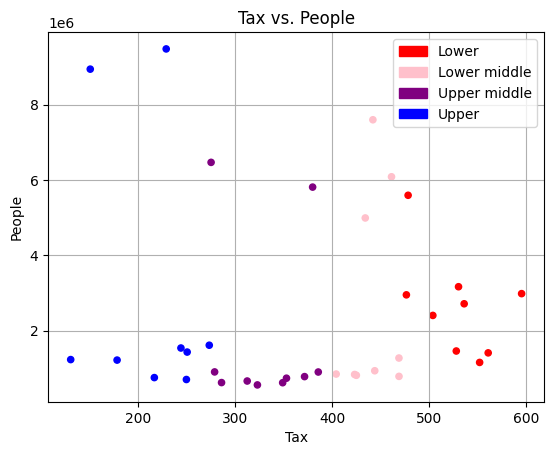

In [ ]:
import sys
import matplotlib # pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

# Convert to Pandas
Pop = Cond_Pop.toPandas() # pip install setuptools
Inc = Cond_Inc.toPandas()
Sta = Statements.toPandas()
Dat = Cast_Data.toPandas()
Reg = Region.toPandas()

# Visualise data
Ages = Dat['All_ages'].values.tolist()
Tax = Dat['Tot_tax'].values.tolist()

# Create blank list
avg_tax = []

for i in range(len(Ages)):
    avg_tax.append(Ages[i]/Tax[i])

'''
# Create line of best fit
z = np.polyfit(x=Dat.loc[:,'All_ages'],y=Dat.loc[:,'Tot_tax'],deg=1)
p = np.poly1d(z)
Dat['Trendline'] = p(Dat.loc[:,'All_ages'])
'''
cat_var = []

# Create category
for i in range(len(avg_tax)):
    if avg_tax[i] > 469:
        cat_var.append('Lower')
    elif avg_tax[i] > 386 and avg_tax[i] < 469:
        cat_var.append('Lower middle')
    elif avg_tax[i] > 275 and avg_tax[i] < 386:
        cat_var.append('Upper middle')
    else:
        cat_var.append('Upper')

# Add cat_var to dataframe
Dat['Class'] = cat_var
Dat['Avg_tax'] = avg_tax

# Create the groups seen in graph
colours = {'Lower': 'red', 'Lower middle': 'pink', 'Upper middle': 'purple', 'Upper': 'blue'}
colour_list = [colours[group] for group in cat_var]

# Create scatter graph
legend_handles = [mpatch.Patch(color=colours['Lower'],label='Lower'),
                  mpatch.Patch(color=colours['Lower middle'],label='Lower middle'),
                  mpatch.Patch(color=colours['Upper middle'],label='Upper middle'),
                  mpatch.Patch(color=colours['Upper'],label='Upper')]

gro_ax = Dat.plot.scatter('Avg_tax','All_ages',c=colour_list,grid=True)
gro_ax.set_title('Tax vs. People')
gro_ax.set_xlabel('Tax')
gro_ax.set_ylabel('People')
gro_ax.legend(handles=legend_handles)

In [67]:
# Get region details into list
Codes = Pop['Code'].values.tolist()
Type = Pop['Geography'].values.tolist()
Geo = Dat['Geography'].values.tolist()

# Create blank 2d list
w, h = len(Codes), 2 
District = [[0]*h for i in range(w)]
c = ''

# Connect each district to its relative region
for i in range(0,len(Geo)):
    if Geo[i] == 'Region':
        c = Codes[i]
    if Geo[i] == 'Country':
        c = 'Country'
    District[i][0] = c
    District[i][1] = Codes[i]

# Instantiate variables
reg = 0
num = 0

reg_tax = []

'''
# Calculate the regions average tax
for i in range(0,len(Geo)):
    current = District[i][0]
    if Geo[i] == 'Country':
        continue
    elif Geo[i]=='Region':
        c = current
        if num!= 0:
            avg = reg // num
            reg_tax.append(avg)
            reg = 0
            num = 0
        elif i == 0:
            reg = avg_tax[0]+avg_tax[1]
            avg = reg // 2
            reg_tax.append(avg)
            reg = 0
            num = 0
        else:
            reg_tax.append(avg_tax[i])
            reg = 0
            num = 0
        reg += avg_tax[i]
        num += 1
    elif Geo[i]!='Country' and Geo[i]!='Region':
        if i == 1:
            reg = 0
            num = 0
            continue
        else:
            reg += avg_tax[i]
            num += 1
    else:
        print('Other')
    print(f"Index {i}: Geo={Geo[i]}, reg={reg}, num={num}")
'''   
# Calculate the regions average tax
for i in range(0, len(Geo)):  # Fix 1: Ensure the last element is included
    current = District[i][0]

    if Geo[i] == 'Country':
        continue
    elif Geo[i] == 'Region':
        c = current
        if num != 0:  # Fix 3: Properly handle num=0 cases
            avg = reg // num
            reg_tax.append(avg)
        else:
            reg_tax.append(avg_tax[i])  # If no previous values, take current tax
        
        # Reset counters
        reg = 0
        num = 0
    else:
        reg += avg_tax[i]
        num += 1
    print(f"Index {i}: Geo={Geo[i]}, reg={reg}, num={num}")  # Debugging



# Add list to dataframe
Reg['Tax'] = reg_tax

display(Reg)

Index 0: Geo=Region, reg=0, num=0
Index 1: Geo=Metropolitan County, reg=551.7760765550239, num=1
Index 2: Geo=Region, reg=0, num=0
Index 3: Geo=Metropolitan County, reg=476.35428109854604, num=1
Index 4: Geo=County, reg=945.0487460431955, num=2
Index 5: Geo=Metropolitan County, reg=1472.7886011156593, num=3
Index 6: Geo=Region, reg=0, num=0
Index 7: Geo=Metropolitan County, reg=560.5864541832669, num=1
Index 8: Geo=Metropolitan County, reg=1064.1841481036024, num=2
Index 9: Geo=Region, reg=0, num=0
Index 10: Geo=County, reg=424.84240837696336, num=1
Index 11: Geo=County, reg=777.7342353000403, num=2
Index 12: Geo=County, reg=1246.4815406892617, num=3
Index 13: Geo=County, reg=1650.5456555217975, num=4
Index 14: Geo=Region, reg=0, num=0
Index 15: Geo=County, reg=385.631330472103, num=1
Index 16: Geo=County, reg=671.6604971387696, num=2
Index 17: Geo=Metropolitan County, reg=1266.657702727592, num=3
Index 18: Geo=County, reg=1615.626452727592, num=4
Index 19: Geo=Region, reg=0, num=0
Ind

Code Geography All_ages                      Name Morrisons Tesco  \
0  E12000001    Region  2711380                NORTH EAST        31  #N/A   
1  E12000002    Region  7600126                NORTH WEST        67  #N/A   
2  E12000003    Region  5594125  YORKSHIRE AND THE HUMBER        55  #N/A   
3  E12000004    Region  4991265             EAST MIDLANDS        39  #N/A   
4  E12000005    Region  6085687             WEST MIDLANDS        48  #N/A   
5  E12000006    Region  6468665                      EAST        47  #N/A   
6  E12000007    Region  8945309                    LONDON        32  #N/A   
7  E12000008    Region  9482507                SOUTH EAST        45  #N/A   
8  E12000009    Region  5811259                SOUTH WEST        48  #N/A   

  Sainsbury         Tax  
0      #N/A  535.845850  
1      #N/A  551.000000  
2      #N/A  490.000000  
3      #N/A  532.000000  
4      #N/A  412.000000  
5      #N/A  403.000000  
6      #N/A  297.000000  
7      #N/A  229.046063  
8      #N/A  245.000000

In [49]:
display(Dat)

All_ages  Num_ind   Mean  Median  Other_num_ind  Other_mean  Other_median  \
0    2711380      929  30200   24700            508        3840            31   
1    1153212      396  30500   25000            197        3800            29   
2    7600126     2690  32000   25000           1410        5930            43   
3    2948633     1030  31800   25000            500        5730            36   
4    1270162      440  30500   24200            265        6250            55   
5    1456562      503  30500   25000            235        4380            29   
6    5594125     1940  30900   24700           1130        5210            43   
7    1407072      478  29800   24400            260        4130            30   
8    2402161      816  31200   25200            472        5000            44   
9    4991265     1810  31700   25000           1010        5780            47   
10    811449      301  31500   24800            182        5640            44   
11    734015      282  33700   26700            178        6750            63   
12    782808      280  30200   24400            162        5350            49   
13    844494      310  32400   25100            186        5660            49   
14   6085687     2100  31600   25100           1160        5780            47   
15    898521      339  32500   25600            205        6340            51   
16    617823      242  37200   27500            152        7660            77   
17   2980936      943  30300   24600            475        4470            38   
18    614185      230  33100   25500            144        7260            66   
19   6468665     2410  38300   27700           1430        8340            77   
20    699573      281  40300   29500            167        7110            67   
21   1536118      563  40300   28500            341       11300            79   
22   1215387      492  46700   30600            311       10100           150   
23    931943      319  30500   25000            192        6120            77   
24    776442      272  32800   25100            176        6640            69   
25   8945309     3500  52700   32000           1730       12600           161   
26   9482507     3570  41900   28300           2250        8650            95   
27    555484      180  33400   24000            129        9540           134   
28   1428559      547  39800   28200            366        7440            71   
29   1610251      582  38800   26700            352        7680            74   
30    750230      293  42100   29800            185        9840            98   
31   1228671      490  56400   32600            339       11400           218   
32    900862      325  37700   27400            218        7760            82   
33   5811259     2080  32000   25100           1340        7030            74   
34    833408      269  30200   24200            199        6880           103   
35    659276      245  34400   25700            164        7580            65   
36   3164404     1090  29800   24800            625        4410            38   

    Tot_num_ind  Tot_mean  Tot_median  Tax_num_ind  Tax_mean  Tax_median  \
0          1230     31500       24900         1230      4110        2230   
1           508     31700       25200          508      4120        2290   
2          3490     34000       25700         3490      4930        2360   
3          1290     33600       25500         1290      4810        2350   
4           600     32900       25200          600      4510        2260   
5           642     32000       25200          642      4310        2310   
6          2550     33000       25300         2550      4590        2300   
7           620     31300       24700          620      4040        2200   
8          1060     32900       25500         1060      4510        2330   
9          2380     33800       25800         2380      4850        2370   
10          411     33200       25200          411      4650        2250   
11          3

In [ ]:
# Imports
#from sklearn.ensemble import RandomForestClassifier # pip3 install -U scikit-learn scipy matplotlib
from pyspark.ml.classification import RandomForestClassifier # pip install setuptools
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

#Cast_Data.printSchema()

# Split data
train_data, test_data = Cast_Data.randomSplit([0.8, 0.2])

# Create classifier
rf = RandomForestClassifier()

# Create target data 
#Cast_Data.summary().show()

Cast_Data.show()

# Create model
#model = rf.fit(train_data)


+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+
|All_ages|Num_ind| Mean|Median|Other_num_ind|Other_mean|Other_median|Tot_num_ind|Tot_mean|Tot_median|Tax_num_ind|Tax_mean|Tax_median|Tot_tax| id|     Code|                Area|
+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+
| 2711380|    929|30200| 24700|          508|      3840|          31|       1230|   31500|     24900|       1230|    4110|      2230|   5060|  1|E12000001|          North East|
| 1153212|    396|30500| 25000|          197|      3800|          29|        508|   31700|     25200|        508|    4120|      2290|   2090|  2|E11000007|         Tyne & Wear|
| 7600126|   2690|32000| 25000|         1410|      5930|          43|       3490|   34000|     25700|       3490|  